<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fanalysis-data-windows/notebooks/analysis_data_windows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Configuración del entorno (compatible con Colab y local)
import os
import sys
from pathlib import Path


# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')   
    # Si estamos en Colab, clonar el repositorio
    !git clone https://github.com/ninja-marduk/ml_precipitation_prediction.git
    %cd ml_precipitation_prediction
    # Instalar dependencias necesarias
    !pip install -r requirements.txt
    !pip install xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn itertools tqdm
    BASE_PATH = '/content/drive/MyDrive/ml_precipitation_prediction'
else:
    # Si estamos en local, usar la ruta actual
    if '/notebooks' in os.getcwd():
        BASE_PATH = Path('..')
    else:
        BASE_PATH = Path('.')

print(f"Entorno configurado. Usando ruta base: {BASE_PATH}")

# Si BASE_PATH viene como string, lo convertimos
BASE_PATH = Path(BASE_PATH)

# Ahora puedes concatenar correctamente
model_output_dir = BASE_PATH / 'models' / 'output'
model_output_dir.mkdir(parents=True, exist_ok=True)

data_output_dir = BASE_PATH / 'data' / 'output'
data_output_dir.mkdir(parents=True, exist_ok=True)

data_file = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation.nc'
print(f"Buscando archivo en: {data_file}")

Entorno configurado. Usando ruta base: ..
Buscando archivo en: ../data/output/complete_dataset_with_features_with_clusters_elevation.nc


ℹ️ No se detectó GPU, usando CPU


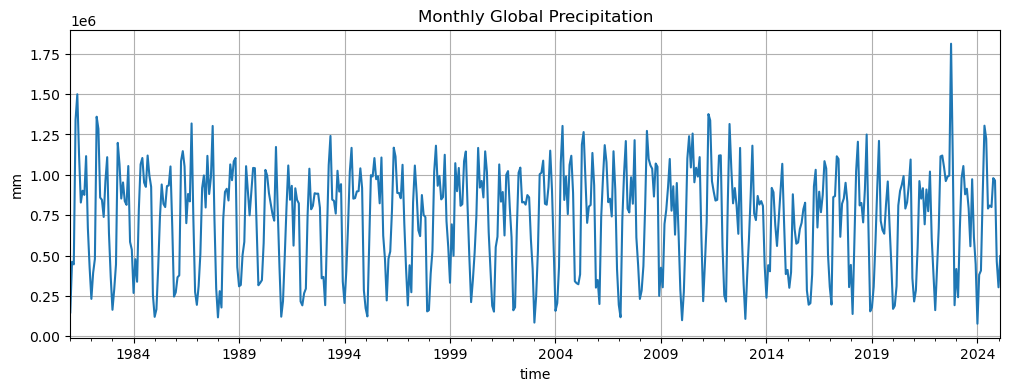

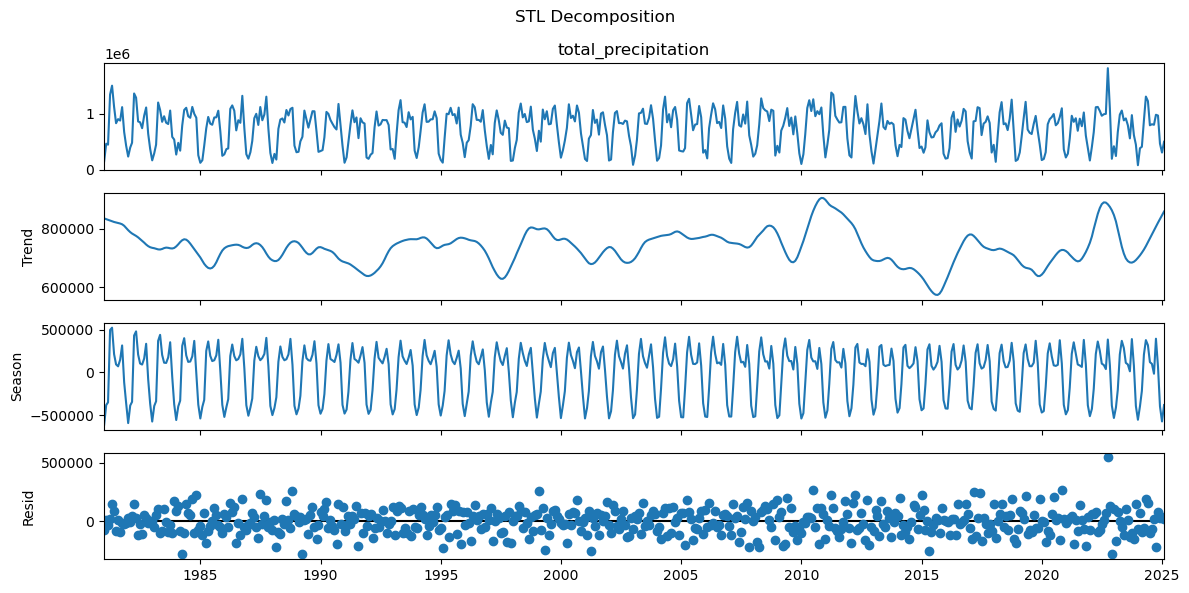

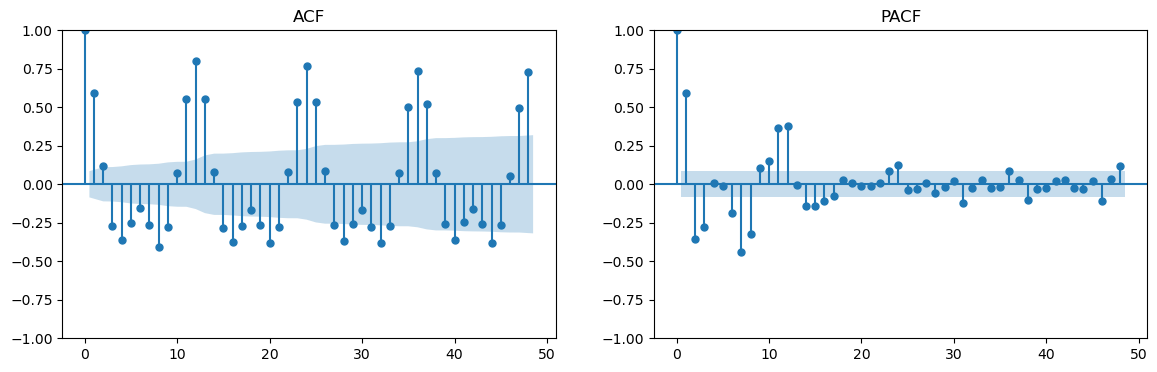

In [5]:
# GPU‐aware + RAM‐optimized pipeline con saneamiento de datos

import os
import warnings

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    ConvLSTM2D,
    MaxPooling2D,
    BatchNormalization,
    Dropout,
    Flatten,
    Dense
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings("ignore")

# 1) Configurar GPU y mixed precision (opcionales)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    device = '/GPU:0'
    print("✅ GPU habilitada, memory_growth ON")
else:
    device = '/CPU:0'
    print("ℹ️ No se detectó GPU, usando CPU")

# Forzamos float32 para evitar problemas de dtype
mixed_precision.set_global_policy('float32')

# 2) Rutas y carga de datos
DATA_PATH  = data_file
MODEL_PATH = model_output_dir
os.makedirs(MODEL_PATH, exist_ok=True)

# Carga de la serie
ds     = xr.open_dataset(DATA_PATH)
precip = ds['total_precipitation'].sum(dim=['latitude','longitude']).to_series()

# 3) Visualización rápida
plt.figure(figsize=(12,4))
precip.plot(title='Monthly Global Precipitation')
plt.ylabel('mm'); plt.grid(); plt.show()

# 4) STL + ACF/PACF
res = STL(precip, seasonal=13).fit()
fig = res.plot(); fig.set_size_inches(12,6)
plt.suptitle('STL Decomposition'); plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1,2,figsize=(14,4))
plot_acf(precip, lags=48, ax=axes[0]); axes[0].set_title('ACF')
plot_pacf(precip, lags=48, ax=axes[1]); axes[1].set_title('PACF')
plt.show()

# Lag Selection & Ventana de Entrenamiento  
*Serie temporal: precipitación mensual (1981 – 2024)*

## 1. Lo que “dicen” la ACF y la PACF

| Lag (meses) | ACF | ¿Significativo? | PACF | Lectura |
|-------------|-----|-----------------|-------|---------|
| **1** | ≈ 0.60 – 0.65 | ✔︎ | ≈ 0.80 | Fuerte memoria inmediata → AR(1) |
| **2 – 4** | 0.30 → 0.15 | ✔︎ (luego cruza banda) | ≈ 0.05 | Arrastre; la relación se explica con el lag 1 |
| **6** | ≈ 0.20 | Marginal | ≈ –0.10 | Semiestacional; incluir solo si tiene sentido físico |
| **12** | ≈ 0.75 | ✔︎ | ≈ 0.30 – 0.35 | Estacionalidad anual marcada → SAR(1) |
| **24** | ≈ 0.55 | ✔︎ | ≈ 0.10 | Segundo ciclo anual (contexto multianual) |
| **36** | ≈ 0.45 | Límite | ≈ 0.05 | Rastro ENSO-like / variabilidad inter-anual |
| **> 40** | < 0.20 | ✖︎ | < 0.05 | Ruido |

**Modelo ARIMA de referencia**  
`SARIMA(1, d, 0) × (1, 0, 0)_12`

---

## 2. Diseño de la ventana de entrada (Deep Learning / ML)

| Objetivo | Lags **mínimos** | Motivo |
|----------|------------------|--------|
| **Memoria inmediata** | 1, 2, 3, 4 | Corrige sesgo del mes anterior y amortigua shocks |
| **Estacionalidad anual** | 12 | Refleja el ciclo pluviométrico dominante |
| **Evitar aliasing** | 11 & 13 | Desfase estacional (phase shift) |
| **Ciclos baja frecuencia** | 24, 36, 48 (± 60) | ENSO, AMO, variabilidad multi-anual |
| **Estabilidad estadística** | Ventana ≥ 48 – 60 meses | 4–5 ciclos anuales completos |

> **Regla práctica para redes ConvLSTM/GRU**  
> `window_size = 60`&nbsp;meses → tensor `[T=60, H, W, C]`

### Implementación rápida

```python
selected_lags = [1, 2, 3, 4, 11, 12, 13, 24, 36, 48]
X = np.stack([series.shift(l) for l in selected_lags], axis=-1)


🔄 Loading dataset from: ../data/output/complete_dataset_with_features_with_clusters_elevation.nc
✅ Dataset loaded successfully

📐 Generating lagged features for variable: total_precipitation
  ➤ Creating lag: total_precipitation_lag1
  ➤ Creating lag: total_precipitation_lag2
  ➤ Creating lag: total_precipitation_lag3
  ➤ Creating lag: total_precipitation_lag4
  ➤ Creating lag: total_precipitation_lag12
  ➤ Creating lag: total_precipitation_lag24
  ➤ Creating lag: total_precipitation_lag36

📦 Merging lagged variables into the dataset...
✅ Lagged variables successfully added

💾 Saving updated dataset with lags to: ../data/output/complete_dataset_with_features_with_clusters_elevation_with_windows.nc
✅ Dataset saved successfully

🔁 Reloading dataset for verification...
✅ Reload successful

📍 Selected location for visualization - Latitude: 5.875, Longitude: -73.32500457763672
📊 Extracting time series for visualization...
✅ Time series and lag features extracted

📈 Generating comparison plo

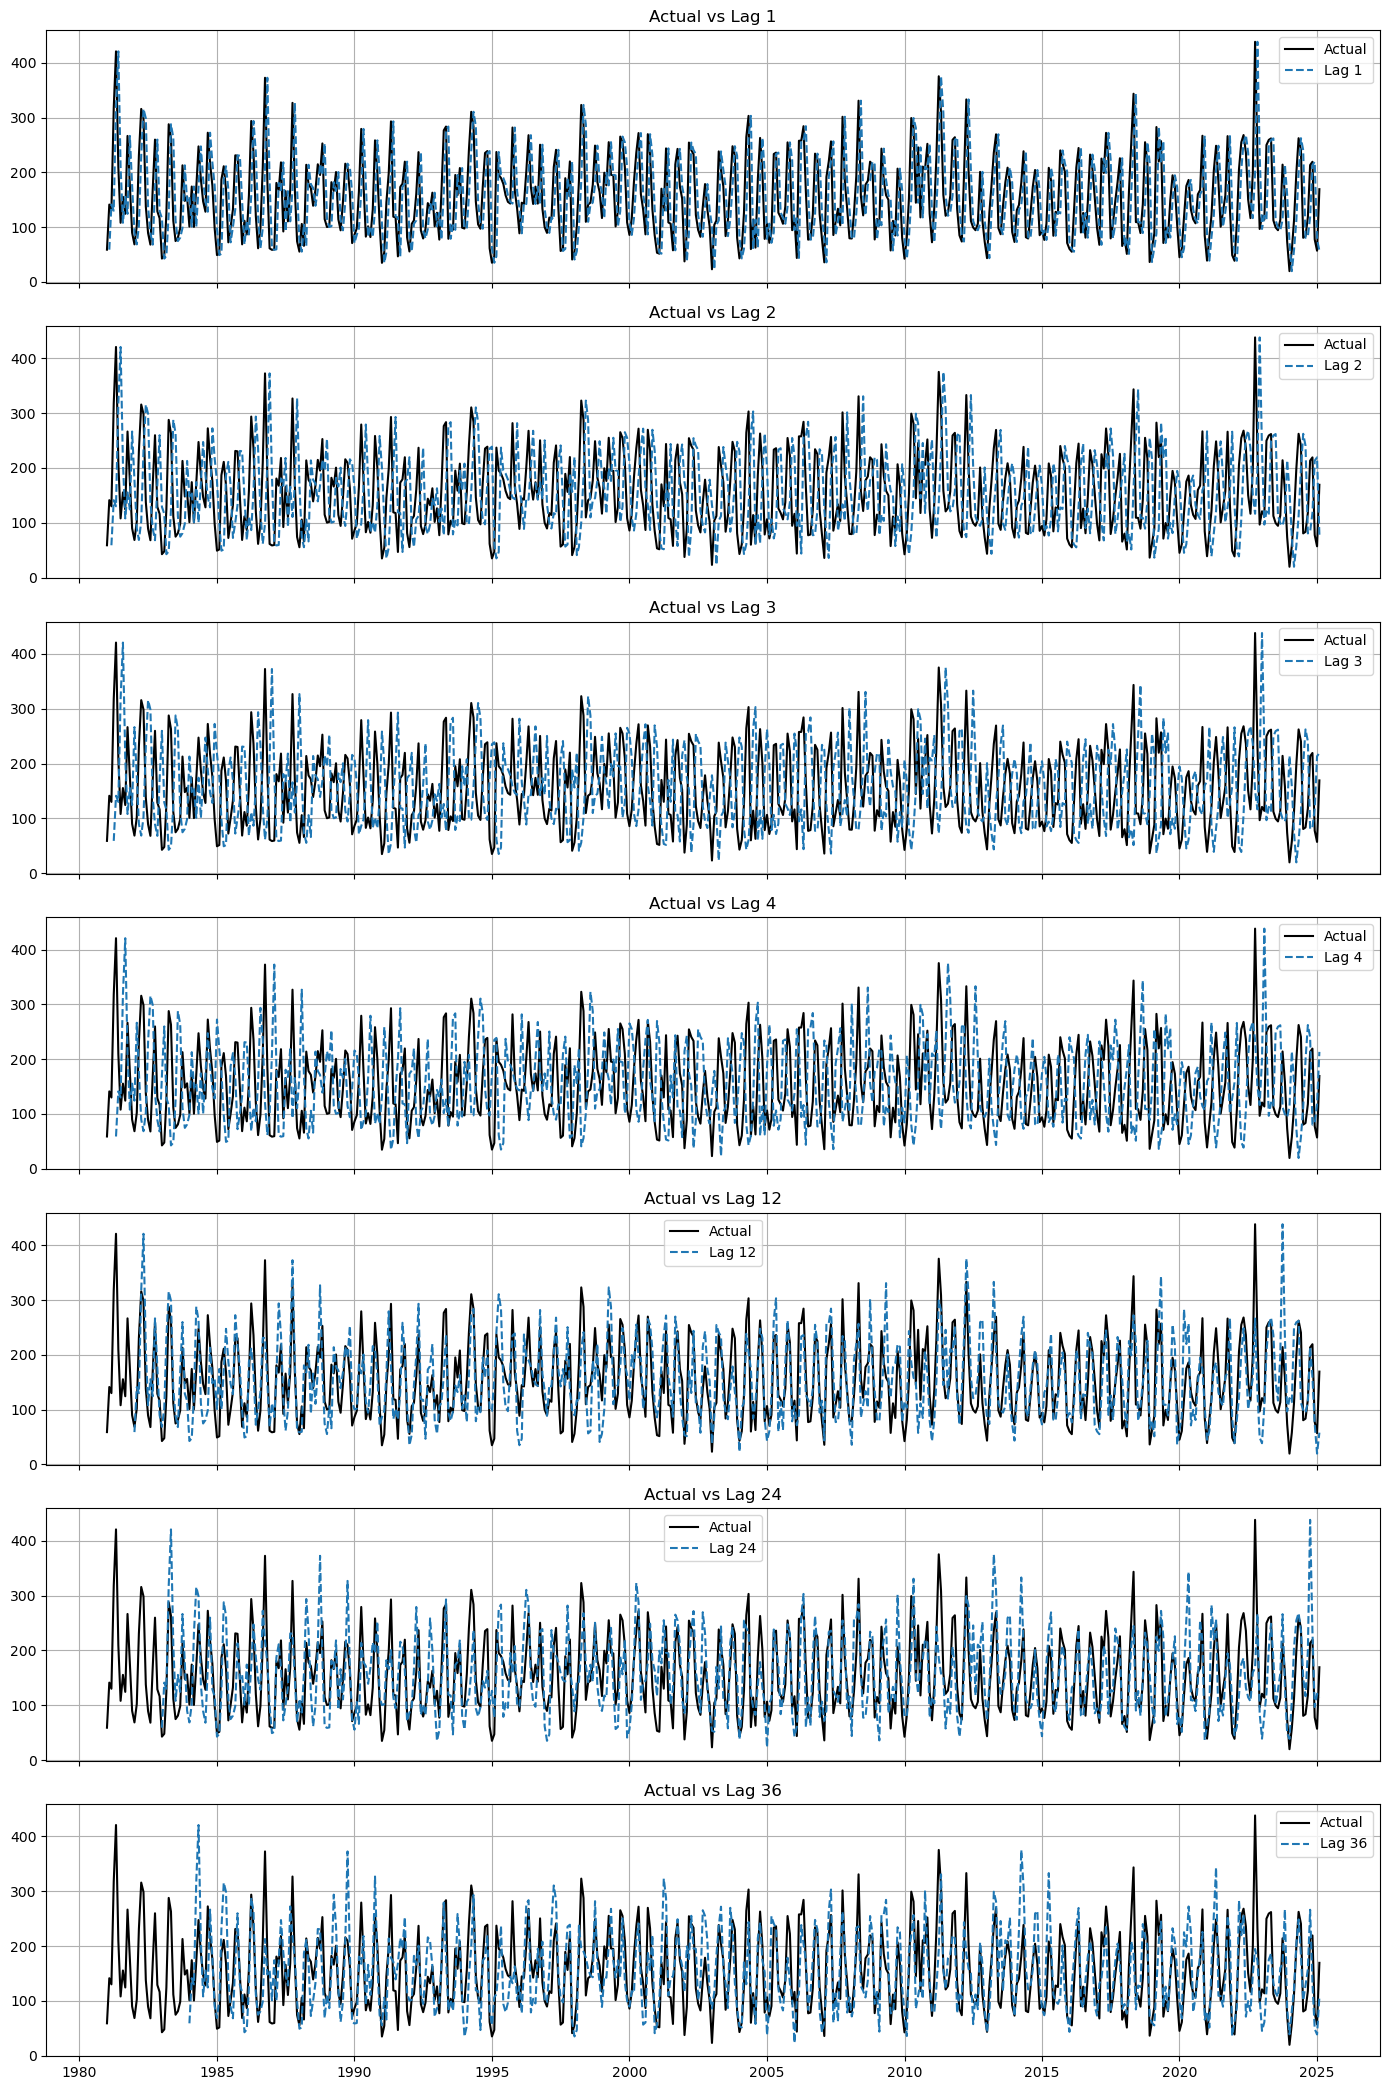

✅ Plotting completed


In [6]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

# Base path configuration
BASE_PATH = Path.cwd()
DATA_DIR = BASE_PATH / 'data' / 'output'

# File paths
input_filename = "complete_dataset_with_features_with_clusters_elevation.nc"
output_filename = "complete_dataset_with_features_with_clusters_elevation_with_windows.nc"
dataset_path = os.path.join(data_output_dir, input_filename)
output_path_with_lags = os.path.join(data_output_dir, output_filename)

# Target variable and lags
target_var = 'total_precipitation'
lags = [1, 2, 3, 4, 12, 24, 36]

# Load dataset
print(f"🔄 Loading dataset from: {dataset_path}")
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"❌ File not found: {dataset_path}")
ds = xr.open_dataset(dataset_path)
print("✅ Dataset loaded successfully")

# Compute lagged features
print(f"\n📐 Generating lagged features for variable: {target_var}")
lagged_vars = {}
for lag in lags:
    var_name = f"{target_var}_lag{lag}"
    print(f"  ➤ Creating lag: {var_name}")
    lagged = ds[target_var].shift(time=lag)
    lagged.name = var_name
    lagged_vars[var_name] = lagged

# Append lagged features to dataset
print("\n📦 Merging lagged variables into the dataset...")
ds_with_lags = ds.copy()
for name, da in lagged_vars.items():
    ds_with_lags[name] = da
print("✅ Lagged variables successfully added")

# Export the new dataset
print(f"\n💾 Saving updated dataset with lags to: {output_path_with_lags}")
ds_with_lags.to_netcdf(output_path_with_lags)
print("✅ Dataset saved successfully")

# Reload and verify
print("\n🔁 Reloading dataset for verification...")
ds_loaded = xr.open_dataset(output_path_with_lags)
print("✅ Reload successful")

# Select a central lat-lon point for visualization
lat_sel = float(ds_loaded.latitude.values[len(ds_loaded.latitude) // 2])
lon_sel = float(ds_loaded.longitude.values[len(ds_loaded.longitude) // 2])
print(f"\n📍 Selected location for visualization - Latitude: {lat_sel}, Longitude: {lon_sel}")

# Extract time series
print("📊 Extracting time series for visualization...")
series_actual = ds_loaded[target_var].sel(latitude=lat_sel, longitude=lon_sel).to_series()
df_lags = pd.DataFrame({f"lag_{lag}": ds_loaded[f"{target_var}_lag{lag}"].sel(latitude=lat_sel, longitude=lon_sel).to_series()
                        for lag in lags})
df_lags["actual"] = series_actual
print("✅ Time series and lag features extracted")

# Plotting
print("\n📈 Generating comparison plots for actual vs lag values...")
fig, axes = plt.subplots(len(lags), 1, figsize=(14, 3 * len(lags)), sharex=True)
for i, lag in enumerate(lags):
    ax = axes[i]
    ax.plot(df_lags["actual"], label="Actual", color='black')
    ax.plot(df_lags[f"lag_{lag}"], label=f"Lag {lag}", linestyle='--')
    ax.set_title(f"Actual vs Lag {lag}")
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()
print("✅ Plotting completed")


### 4. Decisión final

Se recomienda implementar un modelo que utilice una ventana de entrada de **48 meses** con las **7 features** seleccionadas (lags 1–4, 12, 24, 36). Esto permitirá capturar tanto las dependencias inmediatas como las estacionales, optimizando la predicción de **12 meses por delante**. Se hacen las modificaciones en el script _data/transformation/update/dataset_update.py_ de este repositorio.

Teniendo en cuenta los modelos específicos las ventanas de entrada pueden variar de 60 hasta 80 meses, por lo que se recomienda ajustar la ventana de entrada según el modelo a utilizar.